In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')


In [2]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling, RandomZoom
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Set the path to the split dataset directory
split_dataset_dir = '/content/drive/MyDrive/Dataset_divided'


In [4]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
])




In [5]:

# Load data with consistent normalization and get labels for training
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_dataset_dir, 'train'),
    seed=1,
    image_size=(128, 128),
    batch_size=32,
).map(lambda x, y: (data_augmentation(x, training=True), y))
import numpy as np


# Load data with consistent normalization for validation
X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_dataset_dir, 'valid'),
    seed=1,
    image_size=(128, 128),
    batch_size=32,
).map(lambda x, y: (data_augmentation(x, training=False), y))


Found 7350 files belonging to 4 classes.
Found 1578 files belonging to 4 classes.


In [6]:
# Preprocess the data
AUTOTUNE = tf.data.AUTOTUNE
X_train = X_train.prefetch(buffer_size=AUTOTUNE)
X_validation = X_validation.prefetch(buffer_size=AUTOTUNE)

In [7]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increase patience
    restore_best_weights=True
)


In [10]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# EfficientNetB2 model with Batch Normalization and Dropout
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Additional Dense layer with regularization
    BatchNormalization(),
    Dropout(0.5),  # Increase dropout rate
    Dense(4, activation='softmax')
])

# Learning Rate Scheduler Adjustment
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,  # Reduced initial learning rate
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

# Specify the path and filename for saving the model
model_save_path = '/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1)
]

# Data Augmentation Configuration
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])



In [11]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 4, 4, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_3 (Bat  (None, 1408)              5632      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1408)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               180352    
                                                      

In [12]:
# Model Training
history = model.fit(
    X_train,
    epochs=100,
    validation_data=X_validation,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
230/230 [==============================] - 2669s 11s/step - loss: 5.0504 - accuracy: 0.4022 - val_loss: 4.4159 - val_accuracy: 0.4613
Epoch 2/100
230/230 [==============================] - 59s 252ms/step - loss: 4.0906 - accuracy: 0.4635 - val_loss: 3.5409 - val_accuracy: 0.5387
Epoch 3/100
230/230 [==============================] - 60s 256ms/step - loss: 3.3693 - accuracy: 0.5053 - val_loss: 3.2133 - val_accuracy: 0.4905
Epoch 4/100
230/230 [==============================] - 58s 250ms/step - loss: 2.7385 - accuracy: 0.5565 - val_loss: 2.5456 - val_accuracy: 0.5120
Epoch 5/100
230/230 [==============================] - 61s 262ms/step - loss: 2.2049 - accuracy: 0.6121 - val_loss: 2.0172 - val_accuracy: 0.6001
Epoch 6/100
230/230 [==============================] - 58s 250ms/step - loss: 1.7577 - accuracy: 0.6537 - val_loss: 1.6109 - val_accuracy: 0.6711
Epoch 7/100
230/230 [==============================] - 58s 250ms/step - loss: 1.4313 - accuracy: 0.6773 - val_loss: 1.2658 -

In [14]:
# Load the saved model from Google Drive
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')


In [15]:

# Save the entire model to a HDF5 file
model.save('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model from the HDF5 file
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')


In [16]:
# Save the entire model to Google Drive
loaded_model.save('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')

In [17]:
model_evaluate = model.evaluate(X_validation)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

50/50 [==============================] - 6s 102ms/step - loss: 0.1685 - accuracy: 0.9556
Accuracy: % 95.56
Loss: % 16.85


In [18]:

# Save the updated model with the same name
loaded_model.save('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')

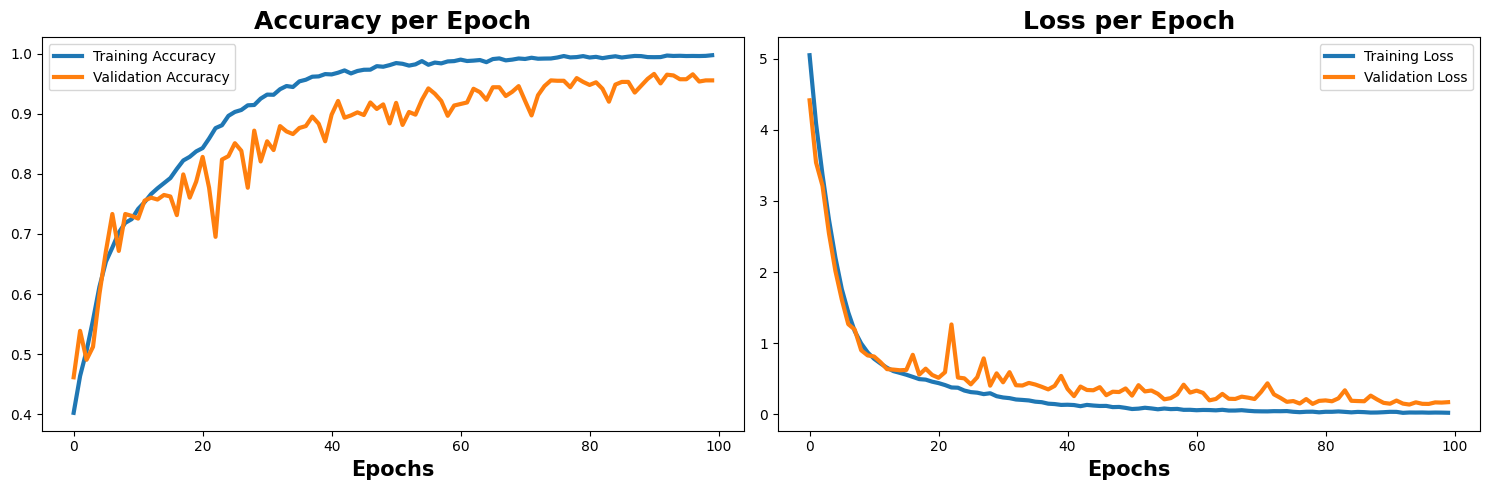

In [19]:
df = pd.DataFrame(history.history)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(df['accuracy'], label='Training Accuracy', lw=3)
ax1.plot(df['val_accuracy'], label='Validation Accuracy', lw=3)
ax1.set_title('Accuracy per Epoch', fontsize=18, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax1.legend()

# Plot loss
ax2.plot(df['loss'], label='Training Loss', lw=3)
ax2.plot(df['val_loss'], label='Validation Loss', lw=3)
ax2.set_title('Loss per Epoch', fontsize=18, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

[]

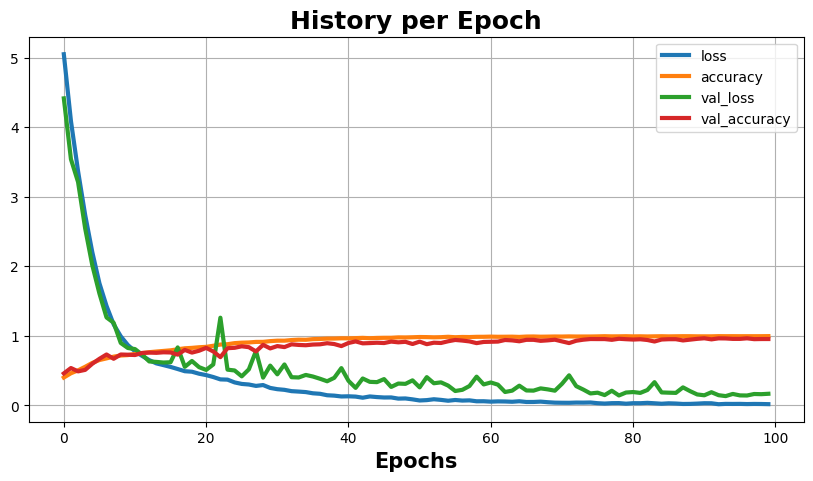

In [20]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
import pandas as pd
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

In [ ]:
# Save the entire model to Google Drive
loaded_model.save('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


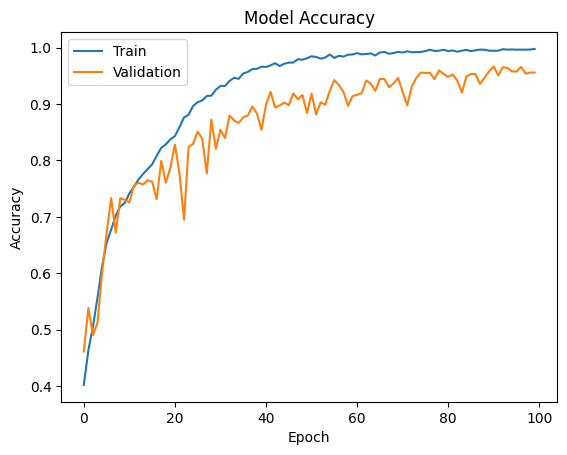

In [22]:
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')

# Visualize Training History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the entire model to a HDF5 file
loaded_model.save('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 1574 images belonging to 4 classes.
Precision: 0.8520
Recall: 0.8231
F1 Score: 0.8156
Accuracy: 0.8024



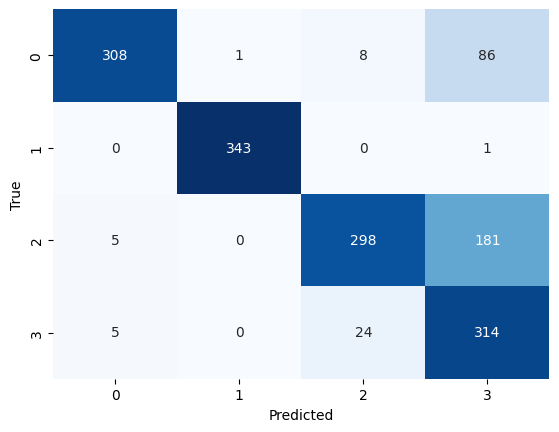

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Get the names of the four classes
class_names = ["Non_Demented", "Very_Mild_Demented", "Moderate_Demented", "Mild_Demented"]

# Set the path to your test dataset directory
test_dataset_dir = os.path.join(split_dataset_dir, 'test')

# Create a data generator for testing
data_generator = ImageDataGenerator(rescale=1.0 / 255.0)

# Load the test data
test_generator = data_generator.flow_from_directory(
    test_dataset_dir,
    target_size=(128, 128),
    batch_size=1,  # Set batch_size to 1 for individual predictions
    class_mode=None,  # Do not specify class_mode for raw predictions
    shuffle=False
)

# Perform individual predictions and calculate metrics for each model
individual_predictions = []

for j in range(len(test_generator.filenames)):
    batch_images = next(test_generator)
    prediction = model.predict(batch_images, verbose=0)
    individual_predictions.append(np.argmax(prediction))

# Calculate and store metrics for the model
precision = precision_score(test_generator.classes, individual_predictions, average='macro')
recall = recall_score(test_generator.classes, individual_predictions, average='macro')
f1 = f1_score(test_generator.classes, individual_predictions, average='macro')
accuracy = accuracy_score(test_generator.classes, individual_predictions)

model_metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy
}

# Print metrics
print(f"Precision: {model_metrics['Precision']:.4f}")
print(f"Recall: {model_metrics['Recall']:.4f}")
print(f"F1 Score: {model_metrics['F1 Score']:.4f}")
print(f"Accuracy: {model_metrics['Accuracy']:.4f}")
print()

# Display confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, individual_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [28]:
# Save the updated model with the same name
loaded_model.save('/content/drive/MyDrive/saved_model/Modified_Efficient_Net_B2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
